In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils.fixes import sp_version, parse_version
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

In [2]:
data = pd.read_csv("C:\\Users\\Lama\\Desktop\\conformal_prediction\\Advertising.csv")

In [3]:
data

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


In [4]:
data.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

In [5]:
data = data.drop_duplicates()

In [6]:
data

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


In [7]:
summary_stats = data.describe().T
summary_stats

,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
Radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
Newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
Sales,200.0,15.1305,5.283892,1.6,11.000,16.00,19.050,27.0


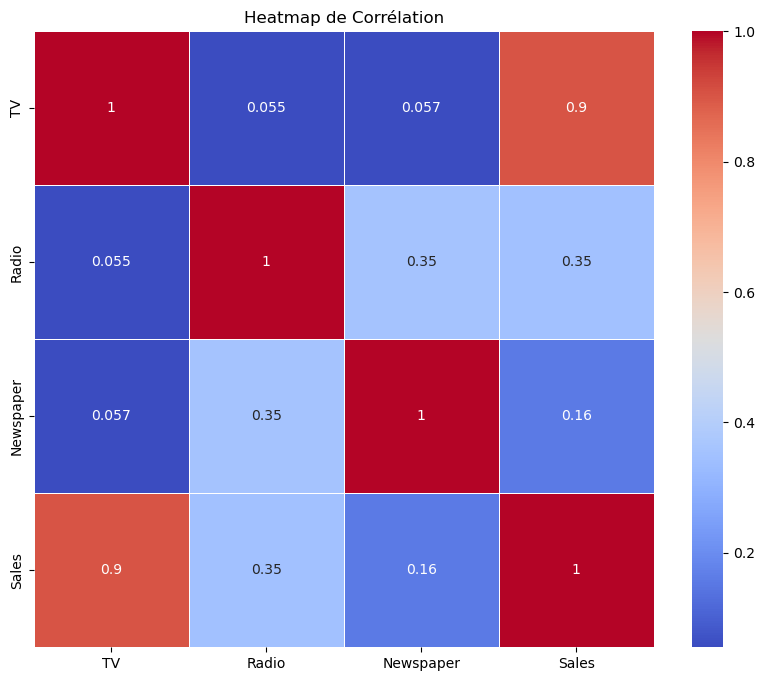

In [8]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de Corrélation')
plt.show()

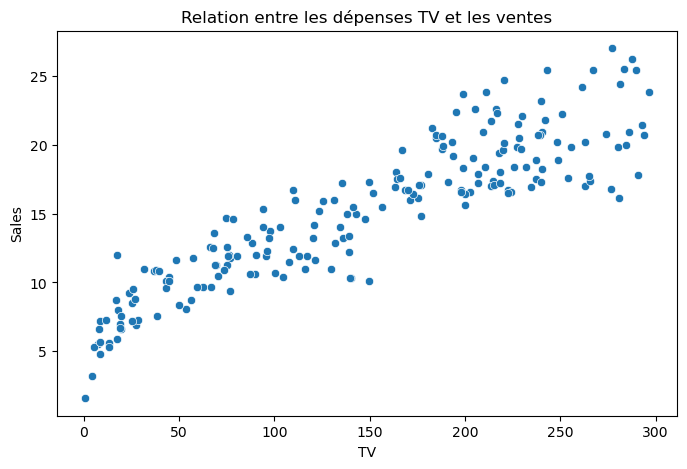

In [9]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='TV', y='Sales', data=data)
plt.title('Relation entre les dépenses TV et les ventes')
plt.show()

# prepapration des données :

In [10]:
#split les données
X = data["TV"]
y = data["Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train= X_train.values.reshape(-1, 1)
X_test= X_test.values.reshape(-1, 1)

# Regression linéaire:

In [11]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

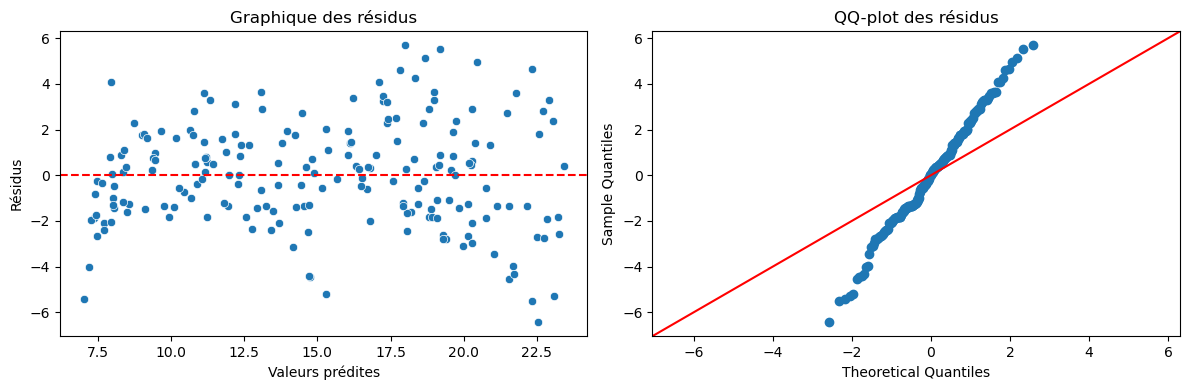

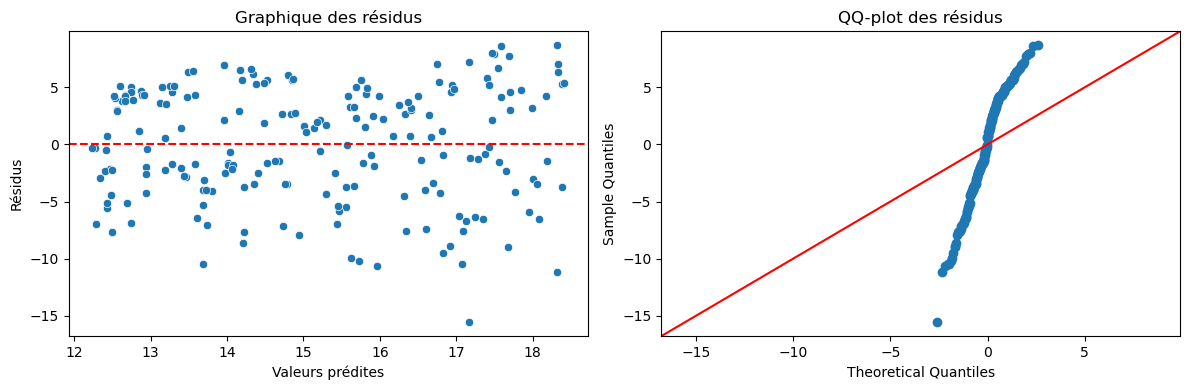

Variable: TV
Test d'homoscédasticité (Breusch-Pagan) p-value: 0.0001
Test de normalité (Shapiro-Wilk) p-value: 0.5269
VIF (Facteur d'Inflation de la Variance): 2.2381

Variable: Radio
Test d'homoscédasticité (Breusch-Pagan) p-value: 0.0008
Test de normalité (Shapiro-Wilk) p-value: 0.0000
VIF (Facteur d'Inflation de la Variance): 2.2381



In [12]:
#Hypothèses du Modèle :
# Fonction pour vérifier les hypothèses de la régression linéaire
def check_regression_assumptions(data, independent_vars, dependent_var):
    results = {}
    for var in independent_vars:
  
        X = data[[var]]
        X = sm.add_constant(X)  
        Y = data[dependent_var]

        # Réalisation de la régression linéaire
        model = sm.OLS(Y, X).fit()
        predictions = model.fittedvalues
        residuals = model.resid

        # Test d'homoscédasticité (Breusch-Pagan)
        bp_test = het_breuschpagan(residuals, model.model.exog)
        bp_pvalue = bp_test[1]

        # Test de normalité des résidus (Shapiro-Wilk)
        shapiro_test = shapiro(residuals)
        shapiro_pvalue = shapiro_test[1]

        # Calcul du VIF pour vérifier la multicollinéarité
        vif = variance_inflation_factor(data[independent_vars].values, independent_vars.index(var))

        # Stockage des résultats
        results[var] = {
            'bp_pvalue': bp_pvalue,
            'shapiro_pvalue': shapiro_pvalue,
            'vif': vif
        }

        # Affichage des graphiques pour l'homoscédasticité et la normalité des résidus
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))

        # Graphique des résidus vs valeurs prédites
        sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
        ax[0].axhline(0, color='red', linestyle='--')
        ax[0].set_title('Graphique des résidus')
        ax[0].set_xlabel('Valeurs prédites')
        ax[0].set_ylabel('Résidus')

        # QQ-plot pour la normalité des résidus
        sm.qqplot(residuals, line='45', ax=ax[1])
        ax[1].set_title('QQ-plot des résidus')

        plt.tight_layout()
        plt.show()

    return results

# Appel de la fonction pour vérifier les hypothèses
independent_vars = ['TV', 'Radio']
dependent_var = 'Sales'
assumption_results = check_regression_assumptions(data, independent_vars, dependent_var)

# Affichage des résultats
for var, result in assumption_results.items():
    print(f"Variable: {var}")
    print(f"Test d'homoscédasticité (Breusch-Pagan) p-value: {result['bp_pvalue']:.4f}")
    print(f"Test de normalité (Shapiro-Wilk) p-value: {result['shapiro_pvalue']:.4f}")
    print(f"VIF (Facteur d'Inflation de la Variance): {result['vif']:.4f}\n")


# visualisation

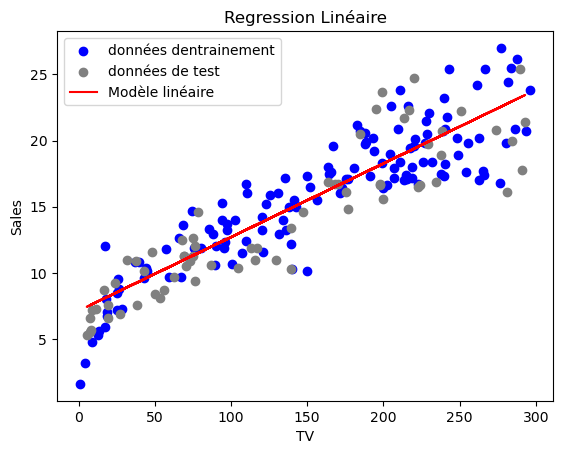

R2 pour la regression linéaire: 0.8025872552039545
MSE de la regression linéaire : 2.3559186485498715


In [13]:
plt.scatter(X_train, y_train, color='blue', marker='o', label='données d''entrainement')  
plt.scatter(X_test, y_test, color='grey', marker='o', label='données de test')   
plt.plot(X_test, y_pred_linear, color='red', label='Modèle linéaire')          

plt.legend()
plt.xlabel('TV')
plt.ylabel('Sales')
plt.title('Regression Linéaire')
plt.show()


#Metrics:
Rtwo_linear_reg = linear_model.score(X_test,y_test)
print("R2 pour la regression linéaire:",Rtwo_linear_reg)

mse_reg_lin=np.sqrt(mean_squared_error(y_test, y_pred_linear))
print("MSE de la regression linéaire :", mse_reg_lin )


# Regression quantile(q=0.5= médiane)

In [14]:
quantile_median_model = QuantileRegressor(quantile=0.5)
quantile_median_model.fit(X_train, y_train)
y_pred_quantile_median = quantile_median_model.predict(X_test)

# Visualisation linéaire & quantile

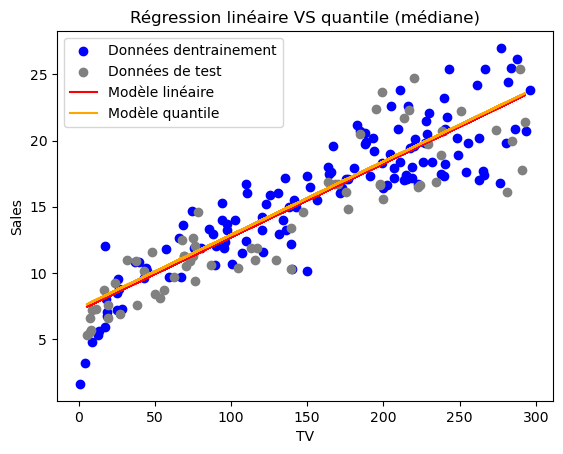

R2 pour la regression linéaire:  0.8025872552039545
MSE pour la regression linéaire: 2.3559186485498715
MSE pour la regression quantile: 2.3991110256881254


In [15]:
plt.scatter(X_train, y_train, color='blue', marker='o', label='Données d''entrainement')  
plt.scatter(X_test, y_test, color='grey', marker='o', label='Données de test')    
plt.plot(X_test, y_pred_linear, color='red', label='Modèle linéaire ')          
plt.plot(X_test, y_pred_quantile_median, color='orange', label='Modèle quantile')             

plt.legend()
plt.xlabel('TV')
plt.ylabel('Sales')
plt.title('Régression linéaire VS quantile (médiane)')
plt.show()


#Metrics:
Rtwo_linear_reg = linear_model.score(X_test,y_test)
print("R2 pour la regression linéaire: ",Rtwo_linear_reg)

mse_reg_lin=np.sqrt(mean_squared_error(y_test, y_pred_linear))
print("MSE pour la regression linéaire:", mse_reg_lin )

mse_reg_quantile = np.sqrt(mean_squared_error(y_test,y_pred_quantile_median))
print("MSE pour la regression quantile:", mse_reg_quantile)




# intervalle de prediction sur regression quantile

# 90%

In [16]:
#creer les 3 modeles:
beta = 0.10  
quantile_reg_low = QuantileRegressor(quantile=beta / 2, alpha=0, solver='highs')  
quantile_reg_high = QuantileRegressor(quantile=1 - beta / 2, alpha=0, solver='highs') 
quantile_median_model = QuantileRegressor(quantile=0.5, alpha=0, solver='highs')  



quantile_median_model.fit(X_train, y_train)
quantile_reg_low.fit(X_train, y_train)
quantile_reg_high.fit(X_train, y_train)


y_pred_quantile_median = quantile_median_model.predict(X_test)
y_pred_quantile_low = quantile_reg_low.predict(X_test)


y_pred_quantile_high= quantile_reg_high.predict(X_test)



C:\Users\Lama\AppData\Local\Temp\ipykernel_16776\440962167.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(X_test, y_pred_quantile_low,'--', color='green', linestyle='dashed', label='q inf')
C:\Users\Lama\AppData\Local\Temp\ipykernel_16776\440962167.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(X_test, y_pred_quantile_high,'--', color='purple', linestyle='dashed', label='q sup')


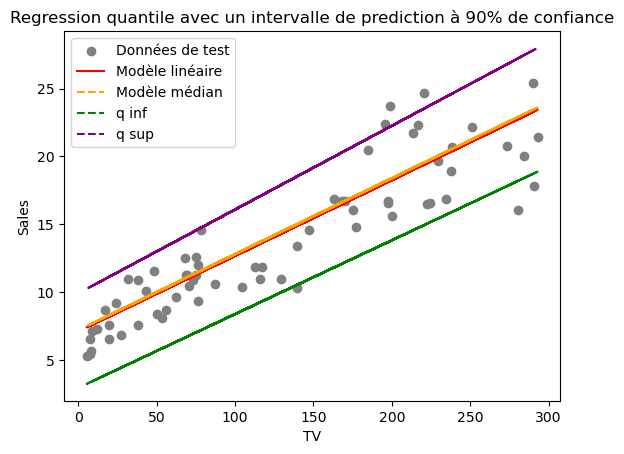

R2 pour la regression linéaire:  0.8025872552039545
MSE pour la regression linéaire: 2.3559186485498715
MSE pour la regression quantile: 2.39150074028865


In [17]:
#plt.scatter(X_train, y_train, color='blue', marker='o', label='Données d''entrainement')
plt.scatter(X_test, y_test, color='grey', marker='o', label='Données de test')
plt.plot(X_test, y_pred_linear, color='red', label='Modèle linéaire')          
plt.plot(X_test, y_pred_quantile_median,'--',color='orange', label='Modèle médian')
plt.plot(X_test, y_pred_quantile_low,'--', color='green', linestyle='dashed', label='q inf')
plt.plot(X_test, y_pred_quantile_high,'--', color='purple', linestyle='dashed', label='q sup')

plt.legend()
plt.xlabel('TV')
plt.ylabel('Sales')
plt.title('Regression quantile avec un intervalle de prediction à 90% de confiance')
plt.show()
Rtwo_linear_reg = linear_model.score(X_test,y_test)
print("R2 pour la regression linéaire: ",Rtwo_linear_reg)

mse_reg_lin=np.sqrt(mean_squared_error(y_test, y_pred_linear))
print("MSE pour la regression linéaire:", mse_reg_lin )

mse_reg_quantile = np.sqrt(mean_squared_error(y_test,y_pred_quantile_median))
print("MSE pour la regression quantile:", mse_reg_quantile)




In [18]:
# Compter les points de test qui sont en dehors des intervalles de prédiction:
out_of_bounds = y_test[(y_test < y_pred_quantile_low) | (y_test > y_pred_quantile_high)]
number_out_of_bounds = out_of_bounds.shape[0]
print(f"Nombre de points de test hors de l'intervalle de prédiction : {number_out_of_bounds}")

Nombre de points de test hors de l'intervalle de prédiction : 6


In [19]:
#compter et imprimer les couverages empiriques et théoriques:
empirical_coverage  = np.sum((y_pred_quantile_low<=y_test)*(y_test<=y_pred_quantile_high))/len(y_test) 
theoretical_coverage = 1-beta
print("Theoretical coverage: ", theoretical_coverage)
print("Empirical coverage with QR: ",empirical_coverage) 

Theoretical coverage:  0.9
Empirical coverage with QR:  0.9090909090909091


# regression polynomiale à plusieurs degrés (1 à 4) pour comparaison

MSE du modèle polynomial de degré 1: 2.355918648549871 (R^2) pour degré 1: 0.8025872552039546
MSE du modèle polynomial de degré 2: 2.298820473278197 (R^2) pour degré 2: 0.8120403101486131
MSE du modèle polynomial de degré 3: 2.38225965153743 (R^2) pour degré 3: 0.798148120598124
MSE du modèle polynomial de degré 4: 2.358260035860279 (R^2) pour degré 4: 0.802194670018365


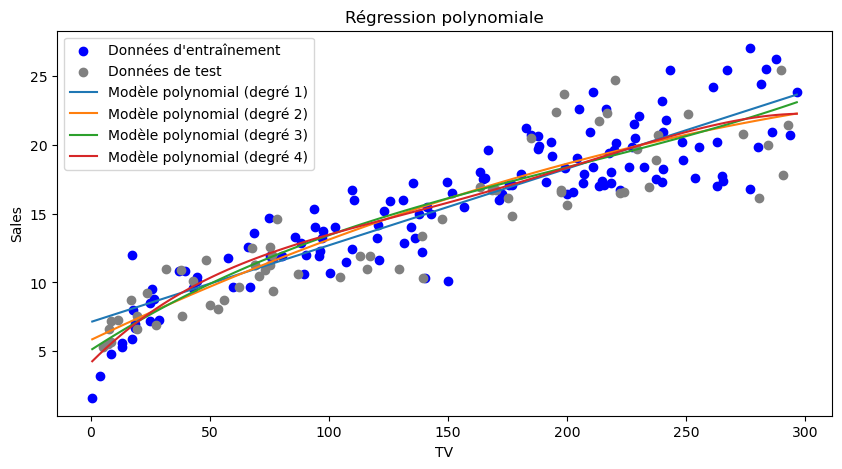

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
plt.figure(figsize=(10,5))
# Tracé des données
plt.scatter(X_train, y_train, color='blue', label='Données d\'entraînement')
plt.scatter(X_test, y_test, color='grey', label='Données de test')

for poly_degree in range(1, 5):  # De 1 à 4
    poly = PolynomialFeatures(degree=poly_degree)
    Xpoly_train = poly.fit_transform(X_train)
    Xpoly_test = poly.transform(X_test)

    # Entraînement du modèle de régression
    linear_reg = LinearRegression(fit_intercept=False)
    linear_reg.fit(Xpoly_train, y_train)

    X_range_poly = poly.transform(X_range)
    y_pred = linear_reg.predict(X_range_poly)

    plt.plot(X_range, y_pred, label=f'Modèle polynomial (degré {poly_degree})')

    # Métriques
    y_pred_test = linear_reg.predict(Xpoly_test)
    mse_reg_poly = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    print(f"MSE du modèle polynomial de degré {poly_degree}:", mse_reg_poly,f"(R^2) pour degré {poly_degree}:", r2)
    
    
plt.xlabel('TV')
plt.ylabel('Sales')
plt.title('Régression polynomiale')
plt.legend()
plt.show()


# Préparation des données pour la régression polynomiale

In [21]:
poly_degree = 2  
poly = PolynomialFeatures(degree=poly_degree)
Xpoly_train = poly.fit_transform(X_train)
Xpoly_test = poly.fit_transform(X_test) 

# prepaprer le modele polynomiale:

In [22]:
linear_reg = LinearRegression(fit_intercept=False)
linear_reg.fit(Xpoly_train, y_train)

LinearRegression(fit_intercept=False)

# visualisation 

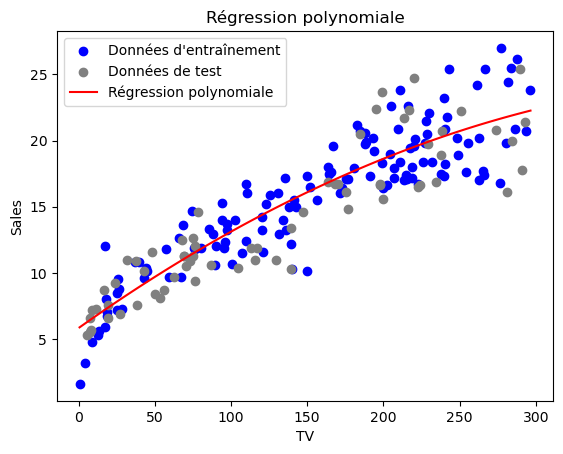

MSE de la regression polynomiale: 2.298820473278197
(R^2): 0.8120403101486131


In [23]:
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  
X_range_poly = poly.transform(X_range)
y_pred = linear_reg.predict(X_range_poly)

y_pred_test = linear_reg.predict(Xpoly_test)


# Tracé des résultats
plt.scatter(X_train, y_train, color='blue', label='Données d\'entraînement')
plt.scatter(X_test, y_test, color='grey', label='Données de test')
plt.plot(X_range, y_pred, color='red', label='Régression polynomiale')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.title('Régression polynomiale')
plt.legend()
plt.show()


#Metrics:
mse_reg_poly=np.sqrt(mean_squared_error(y_test, y_pred_test))
print("MSE de la regression polynomiale:", mse_reg_poly )


# Calcul du coefficient de détermination (R^2)
r2 = r2_score(y_test, y_pred_test)
print("(R^2):", r2)


# Appliquer une régression quantile polynomiale

In [24]:
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
qr_med = QuantileRegressor(quantile=0.5, alpha=0,solver='highs')
qr_med.fit(Xpoly_train, y_train)  
y_pred_quantile_median = qr_med.predict(Xpoly_test)


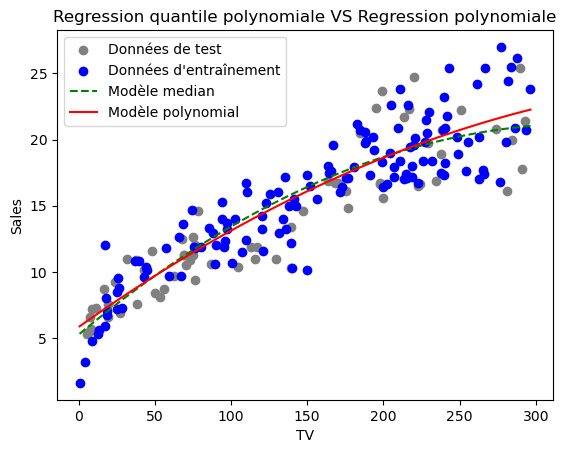

MSE de la regression polynomiale: 2.298820473278197
MSE de la regression quantile (médiane) : 2.3228910681620447


In [25]:
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_range_poly = poly.transform(X_range)

plt.scatter(X_test, y_test, color='grey', marker='o', label='Données de test')
plt.scatter(X_train, y_train, color='blue', label='Données d\'entraînement')
plt.plot(X_range, qr_med.predict(X_range_poly), '--', color='green', label='Modèle median')
plt.plot(X_range, linear_reg.predict(X_range_poly), color='red', label='Modèle polynomial')

plt.legend()
plt.xlabel('TV')
plt.ylabel('Sales')
plt.title('Regression quantile polynomiale VS Regression polynomiale')
plt.show()

mse_reg_poly=np.sqrt(mean_squared_error(y_test, y_pred_test))
print("MSE de la regression polynomiale:", mse_reg_poly )
mse_reg_med=np.sqrt(mean_squared_error(y_test, y_pred_quantile_median))
print("MSE de la regression quantile (médiane) :", mse_reg_med )


# intervale de prediction de regression polynomiale quantile à 90%

In [26]:
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
beta = 0.10
qr_down = QuantileRegressor(quantile=beta/2, alpha=0,solver='highs')
qr_up = QuantileRegressor(quantile=1-beta/2, alpha=0,solver='highs')

qr_down.fit(Xpoly_train, y_train) 
qr_up.fit(Xpoly_train, y_train)   

y_pred_quantile_low= qr_down.predict(Xpoly_test)
y_pred_quantile_high= qr_up.predict(Xpoly_test)

C:\Users\Lama\AppData\Local\Temp\ipykernel_16776\1973040157.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(X_range, qr_down.predict(X_range_poly), '--', color='green', linestyle='dashed', label='q inf')
C:\Users\Lama\AppData\Local\Temp\ipykernel_16776\1973040157.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(X_range, qr_up.predict(X_range_poly), '--', color='purple', linestyle='dashed', label='q sup')


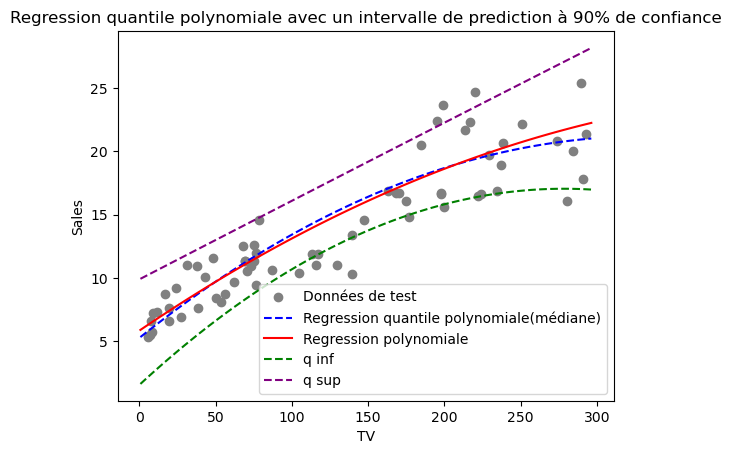

MSE de la regression polynomiale: 2.298820473278197
MSE de la regression quantile polynomiale(médiane) : 2.3228910681620447


In [27]:
y_pred_test = linear_reg.predict(Xpoly_test)
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_range_poly = poly.transform(X_range)

plt.scatter(X_test, y_test, color='grey', marker='o', label='Données de test')
plt.plot(X_range, qr_med.predict(X_range_poly), '--', color='blue', label='Regression quantile polynomiale(médiane)')
plt.plot(X_range, linear_reg.predict(X_range_poly), color='red', label='Regression polynomiale')
plt.plot(X_range, qr_down.predict(X_range_poly), '--', color='green', linestyle='dashed', label='q inf')
plt.plot(X_range, qr_up.predict(X_range_poly), '--', color='purple', linestyle='dashed', label='q sup')

plt.legend()
plt.xlabel('TV')
plt.ylabel('Sales')
plt.title('Regression quantile polynomiale avec un intervalle de prediction à 90% de confiance')
plt.show()

mse_reg_poly=np.sqrt(mean_squared_error(y_test, y_pred_test))
print("MSE de la regression polynomiale:", mse_reg_poly )
mse_reg_med=np.sqrt(mean_squared_error(y_test, y_pred_quantile_median))
print("MSE de la regression quantile polynomiale(médiane) :", mse_reg_med )

In [28]:
# Compter les points de test qui sont en dehors des intervalles de prédiction:
out_of_bounds = y_test[(y_test < y_pred_quantile_low) | (y_test > y_pred_quantile_high)]
number_out_of_bounds = out_of_bounds.shape[0]
print(f"Nombre de points de test hors de l'intervalle de prédiction : {number_out_of_bounds}")

Nombre de points de test hors de l'intervalle de prédiction : 10


In [29]:
#compter et imprimer les couverages empiriques et théoriques:
theor_cov = 1-beta # TODO OPERAND
prop_covered_qr  = np.sum((y_pred_quantile_low<=y_test)*(y_test<=y_pred_quantile_high))/len(y_test) # TODO OPERAND
print("Theoretical coverage: ", theor_cov)
print("Empirical coverage with QR: ", prop_covered_qr)

Theoretical coverage:  0.9
Empirical coverage with QR:  0.8484848484848485
